In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ocde_data = pd.read_csv('data/OCDE.csv')

In [2]:
locations = list(set(np.array(ocde_data['LOCATION'])))
nb_locations = len(locations)
x=[]

for l in locations:
    a = ocde_data.loc[ocde_data['LOCATION'] == l]
    x.append(np.array(a[['TIME', 'Value']].copy()))

In [40]:
print(x[0].shape)

(252, 2)


In [4]:
y = []
for i in range(0,nb_locations):
    nb_dates = len(x[i])
    yi = []
    for j in range(nb_dates-1):
        if x[i][j+1][1]>x[i][j][1]:
            yi.append([0,1])
        else:
            yi.append([1,0])
    y.append(yi)


In [53]:
def average_up(x, y_train):
    sum_v = 0
    cpt = 0
    for i in range(len(y_train)):
        if y_train[i][1]==1:
            cpt+=1
            sum_v+=x[0][i+1][1]-x[0][i][1]
    return sum_v/cpt
            

In [56]:
def average_down(x,y_train):
    sum_v = 0
    cpt = 0
    for i in range(len(y_train)):
        if y_train[i][0]==1:
            cpt+=1
            sum_v+=x[0][i][1]-x[0][i+1][1]
    return sum_v/cpt

In [31]:
import numpy as np
from scipy.stats import logistic
# from the file NeuralNetwork.py we import the Multi-Layer Perceptron
from NeuralNetwork import MLP

In [32]:
def d_sigmoid(a) :
    '''
    Derivative of sigmoid activation function. It can work with single inputs or vectors or matrices.
    Return the sigmoid derivative of a
    '''
    ################# YOUR CODE HERE ####################

    x = MLP.sigmoid(a)
    
    return x*(1-x)
    
    ################ END OF YOUR CODE HERE ##############
    
MLP.d_sigmoid=d_sigmoid

In [33]:
def forward(self, x) :
    '''
    Forward function. From input layer to output layer. Input can handle 1D or 2D inputs.

    INPUTS:
    - x : numpy array of size NxD, where N is the number of samples, D is the number of input dimensions referred as n_input before

    OUTPUTS:
    - y_hat : numpy array of size NxC, where C is the number of classes
    '''
    ################# YOUR CODE HERE ####################
    nb_layers = len(self.layer)
    
    def sample_by_sample_forward(s):
        self.layer[0].a = np.expand_dims(np.matmul(self.layer[0].W, s), axis = 1) + np.transpose(self.layer[0].b)
        self.layer[0].z = MLP.sigmoid(self.layer[0].a)

        for i in range(1,nb_layers):
            self.layer[i].a = np.add(np.matmul(self.layer[i].W, self.layer[i-1].z), np.transpose(self.layer[i].b))
            self.layer[i].z = MLP.sigmoid(self.layer[i].a)
        y_hat = self.layer[nb_layers-1].z
        return y_hat
    
    if (x.ndim == 1):
        return sample_by_sample_forward(x)
    
    nb_samples = len(x)
    y_hat = []
    for s in range(nb_samples):
        y_hat.append(sample_by_sample_forward(x[s]))
    return y_hat
    
    
    ################ END OF YOUR CODE HERE ##############
    return y_hat

MLP.forward=forward

In [8]:
def loss(y_hat, y) :
    '''
    Compute the loss between y_hat and y! they can be 1D or 2D arrays!

    INPUTS:
    - y_hat : numpy array of size NxC, N number of samples, C number of classes. It contains the estimated values of y
    - y : numpy array of size NxC with one 1 in each row, corresponding to the correct class for that sample

    OUTPUTS:
    - L : MSE loss
    '''
    ################# YOUR CODE HERE ####################

    N = len(y_hat)
    C = len(y_hat[0])
    diff = [0]*C
    for i in range(C):
        diff[i] += 1/2*(np.sum((y[i]-np.transpose(y_hat[i]))**2, axis = 1))
    L = np.sum(diff)/N
    
    ################ END OF YOUR CODE HERE ##############
    return L

MLP.loss=loss

In [9]:
def accuracy(y_hat,y) :
    '''
    Compute the accuracy between y_hat and y

    INPUTS:
    - y_hat : numpy array of size NxC, C number of classes. It contains the estimated values of y
    - y : numpy array of size NxC with correct values of y

    OUTPUTS:
    - acc : the accuracy value between 0 and 1
    '''
    ################# YOUR CODE HERE ####################

    N = len(y_hat)
    S=0
    for i in range(N):
        if np.argmax(y_hat[i])==np.argmax(y[i]):
            S+=1
    acc = S/N

    ################ END OF YOUR CODE HERE ##############
    return acc

MLP.accuracy=accuracy

In [10]:
def backpropagation(self,x,y,y_hat,learning_rate) :
    '''
    Backpropagate the error from last layer to input layer and then update the parameters

    INPUTS:
    - y_hat : numpy array of size NxC, C number of classes. It contains the estimated values of y
    -y : numpy array of size NxC with correct values of y

    OUTPUTS: (compute the error at the different levels and for each layer)
    - d_a
    - d_z
    - delta_L
    - delta_l
    - d_W
    - d_b
    '''
# compute gradients

    ################# YOUR CODE HERE ####################
    nb_layers = len(self.layer)
    
    for l in range(nb_layers-1, -1, -1):
        if l==nb_layers-1:
            delta_l = y_hat - np.expand_dims(y, axis=1)
        else:
            delta_l = np.matmul(np.transpose(self.layer[l+1].d_a), self.layer[l+1].W)
        self.layer[l].d_z = delta_l
        if l!=0:
            self.layer[l].d_a = np.multiply(delta_l, d_sigmoid(self.layer[l].a))
        else: 
            self.layer[0].d_a = np.multiply(np.transpose(delta_l), d_sigmoid(self.layer[0].a))
        self.layer[l].d_b = self.layer[l].d_a
        if l==0:
            X = x
        else:
            X = np.transpose(self.layer[l-1].z)
        self.layer[l].d_W = np.matmul(self.layer[l].d_a, X)


    ################ END OF YOUR CODE HERE ##############

# apply gradients
    # just one for loop passing through all layers is sufficient
    # apply the gradients only to self.layer[i].b and self.layer[i].W

    ################# YOUR CODE HERE ####################
    
    for l in range(nb_layers):
        self.layer[l].W -= learning_rate*self.layer[l].d_W
        self.layer[l].b -= learning_rate*np.transpose(self.layer[l].d_b)
    
    ################ END OF YOUR CODE HERE ##############
    
MLP.backpropagation=backpropagation

In [22]:
x_train=np.expand_dims(np.array(x[0][0:200,1]),axis=1)
x_train = x_train.astype('float64')
y_train=np.array(y[0][0:200])
x_test=np.expand_dims(np.array(x[0][200:-2,1]),axis=1)
x_test = x_test.astype('float64')
y_test=np.array(y[0][200:-1])

In [12]:
print(x_train.shape)
print(len(y[0]))

(200, 1)
251


TRAINING
Epoch 0 : loss = 1.40037e-03, accuracy = 56.50 %
Epoch 10 : loss = 1.79654e-03, accuracy = 56.50 %
Epoch 20 : loss = 2.74641e-03, accuracy = 61.50 %
Epoch 30 : loss = 3.24137e-03, accuracy = 62.50 %
Epoch 40 : loss = 3.39773e-03, accuracy = 63.00 %
Epoch 50 : loss = 3.43790e-03, accuracy = 64.00 %
Epoch 60 : loss = 3.44314e-03, accuracy = 63.50 %
Epoch 70 : loss = 3.43822e-03, accuracy = 63.50 %
Epoch 80 : loss = 3.43069e-03, accuracy = 63.50 %
Epoch 90 : loss = 3.42295e-03, accuracy = 63.50 %
final : loss = 3.416e-03 , accuracy = 63.50 %

TEST
loss = 8.405e-04 , accuracy = 62.00 %



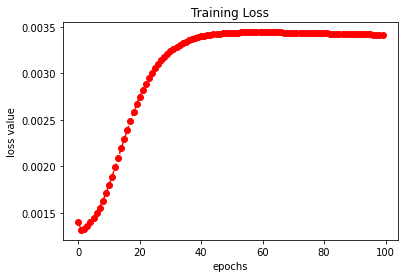

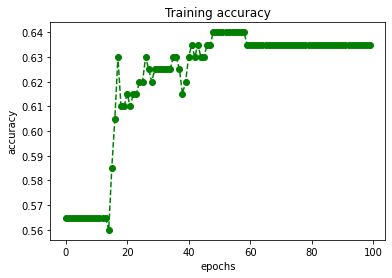

In [14]:
epochs=100
learning_rate=0.05
verbose=True
print_every_k=10

# Initialization of the NN
NN1 = MLP([1, 10, 2])
print('TRAINING')
# Training
NN1.training(x_train,y_train,learning_rate,epochs,verbose,print_every_k)
# Compute the training loss and accuracy after having completer the training
y_hat=NN1.forward(x_train)
print('final : loss = %.3e , accuracy = %.2f %%'%(MLP.loss(y_hat,y_train),100*MLP.accuracy(y_hat,y_train)))

# Test
print('\nTEST')
y_hat=NN1.forward(x_test)
print('loss = %.3e , accuracy = %.2f %%\n'%(MLP.loss(y_hat,y_test),100*MLP.accuracy(y_hat,y_test)))

plt.plot(list(range(epochs)),NN1.losses,c='r',marker='o',ls='--');
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.show()

plt.plot(list(range(epochs)),NN1.accuracies,c='g',marker='o',ls='--');
plt.title("Training accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()


In [15]:
years_ago = 3

In [86]:
x_train = np.array([[x[0][i-k,1] for k in range(years_ago)] for i in range (years_ago, 100)])
x_train = x_train.astype('float64')
y_train=np.array(y[0][years_ago:100])
x_test= np.array([[x[0][i-k,1] for k in range(years_ago)] for i in range (100, 251)])
x_test = x_test.astype('float64')
y_test=np.array(y[0][100:252])
avg_up = average_up(x, y_train)
avg_down = average_down(y, y_train)
print(avg_up)

0.05297454545454545


TRAINING
Epoch 0 : loss = 2.73966e-03, accuracy = 56.70 %
Epoch 10 : loss = 2.91034e-03, accuracy = 56.70 %
Epoch 20 : loss = 2.99494e-03, accuracy = 56.70 %
Epoch 30 : loss = 2.88243e-03, accuracy = 56.70 %
Epoch 40 : loss = 2.64375e-03, accuracy = 56.70 %
Epoch 50 : loss = 2.30117e-03, accuracy = 56.70 %
Epoch 60 : loss = 1.92952e-03, accuracy = 56.70 %
Epoch 70 : loss = 1.62023e-03, accuracy = 58.76 %
Epoch 80 : loss = 1.38099e-03, accuracy = 64.95 %
Epoch 90 : loss = 1.18490e-03, accuracy = 65.98 %
Epoch 100 : loss = 1.02498e-03, accuracy = 67.01 %
Epoch 110 : loss = 8.97290e-04, accuracy = 64.95 %
Epoch 120 : loss = 7.91882e-04, accuracy = 64.95 %
Epoch 130 : loss = 7.00404e-04, accuracy = 64.95 %
Epoch 140 : loss = 6.19646e-04, accuracy = 64.95 %
Epoch 150 : loss = 5.49444e-04, accuracy = 64.95 %
Epoch 160 : loss = 4.90138e-04, accuracy = 63.92 %
Epoch 170 : loss = 4.41498e-04, accuracy = 63.92 %
Epoch 180 : loss = 4.02680e-04, accuracy = 63.92 %
Epoch 190 : loss = 3.72518e-04, a

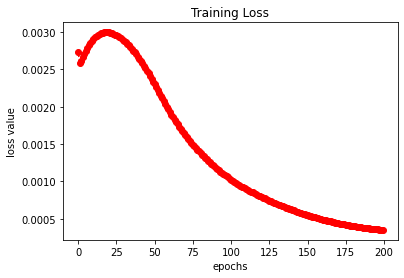

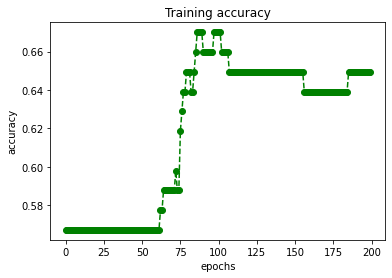

In [87]:
epochs=200
learning_rate=0.1
verbose=True
print_every_k=10

# Initialization of the NN
NN1 = MLP([3, 10, 2])
print('TRAINING')
# Training
NN1.training(x_train,y_train,learning_rate,epochs,verbose,print_every_k)
# Compute the training loss and accuracy after having completer the training
y_hat=NN1.forward(x_train)
print('final : loss = %.3e , accuracy = %.2f %%'%(MLP.loss(y_hat,y_train),100*MLP.accuracy(y_hat,y_train)))

# Test
print('\nTEST')
y_hat=NN1.forward(x_test)
print('loss = %.3e , accuracy = %.2f %%\n'%(MLP.loss(y_hat,y_test),100*MLP.accuracy(y_hat,y_test)))

plt.plot(list(range(epochs)),NN1.losses,c='r',marker='o',ls='--');
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.show()

plt.plot(list(range(epochs)),NN1.accuracies,c='g',marker='o',ls='--');
plt.title("Training accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

251
247


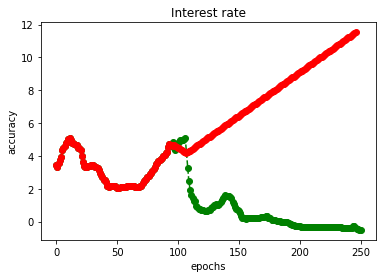

In [88]:
true_plot= x[0][1:len(x[0]),1]
l_x_train = len(x_train)
predicted_plot = [x[0][i][1] for i in range(1, l_x_train)]


for i in range(len(x_test)):
    if y_hat[i][0]>y_hat[i][1]:
        predicted_plot.append(predicted_plot[l_x_train + i -2] - avg_down)
    else:
        predicted_plot.append(predicted_plot[l_x_train + i -2] + avg_up)

print(len(true_plot))
print(len(predicted_plot))

plt.plot(true_plot,c='g',marker='o',ls='--');
plt.plot(predicted_plot,c='r',marker='o',ls='--');
plt.title("Interest rate")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()